## Cancer Stem Cell Model-- Tumor simulation
Agent model based on 

### CSC neutral model

In [208]:
import pandas as pd
import numpy as np
import random
import copy
import baltic as bt
#create classes
class Cell:
    def __init__(self):
        self.parent = None #cell it was derived from
        self.children = [] #set of daughter cells
        self.locx = None #x location in lattice
        self.locy = None #y location in lattice
        self.birthdate = None
        self.deathdate = None
        self.pmax = 10 #proliferation potential
        self.cellnum = None #unique cell number to identify
        self.alpha = 0.01 #probability of sponaneous death
        self.mutation_rate = 0.1 #probability of mutation per cell division
        self.motility = None #probability of migration per day
        self.proliferation_rate = 1 #average cell divisions per day
        self.clone = None
        self.mutations = []
        self.ps = 0
        self.curnode = None
        self.new_mut = False

class StemCell(Cell): #define stem cell class
    def __init__(self):
        Cell.__init__(self)
        self.pmax = float('inf') #infinite proliferation potential
        self.alpha = 0 #immortal
        self.ps = 0 #probability of symmetric division

# class Clone(): #define clone class
#     def __init__(self):
#         self.parent = None
#         self.children = []
#         self.birthdate = None
#         self.deathdate = None
#         self.color = None
#         self.clonenum = None
#         self.mutations = []
#         self.alive_cells = []
#         self.node = None
# class Mutation(): #definate mutation class
#     def __init__(self):
#         self.cells = []
#         self.alive_cells = []
#         self.mutnum = 'None'
        
#create lattice array
N = 10000 # starting demensions of lattice
lattice = np.empty( (N,N), dtype=object)

#parameters
proliferation_rate_CC = 2
proliferation_rate_CSC = 1
pmax_CC = 10
migration_potential = 15
alpha_CC = 0.05
cur_cellnum = 0
cur_mutnum = 0
cur_clonenum = 1
cur_index = 1
mutation_rate = 0.1

tree = bt.tree()
root = bt.node()
root.length=0 ## branch length,
root.height=0 ## height, set by traversing the tree, which adds up branch lengths along the way
root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
root.index='root' ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
root.x=0## X and Y coordinates of this node, once drawTree() is called
root.alive_cells = []
tree.Objects.append(root)
tree.nodes.append(root)
tree.root = root
root.clone = 'o'

alive_cells = []
cells = []
mutations = []
clones = ['a','b','c','d']

i = int(N/2) #to place founder cell in center of lattic
modi = [0,0,1,1]
modj = [0,1,0,1]
for x in range(4):
    Fcell = StemCell() #initiate founder cell
    Fcell.locx = i+modi[x] #x location in lattice
    Fcell.locy = i+modj[x] #y location in lattice
    Fcell.birthdate = 0
    Fcell.cellnum = 0  #unique cell number to identify
    Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
    Fcell.motility = migration_potential #probability of migration per day
    Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per da
    Fcell.ps = 0.05
    Fcell.clone = clones[x]
    Fcell.curnode = root
    cells.append(Fcell)
    alive_cells.append(Fcell)
    Fcell.curnode.alive_cells.append(Fcell)

#initial founder clone object
# Fclone = Clone()
# Fclone.clone_num = 0
# Fclone.birthdate = 0
# Fcell.clone = Fclone
# Fclone.alive_cells.append(Fcell)
#Fclone.node = root

#initiate desired tracking system
#simpsons_diversity = [] #list to keep track of diversity at each time step
#clones = [] #list to contain each clone in population
#clones.append(Fclone) #add founding clone to list



#time parameters
dt = 1/float(24) # time is equilavent to 1/24 of a day or 1 hour
time = 0 #initialize time to 0
stop_time =20 #stop simulation after this many days


def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells


while time < stop_time:
    time += dt
    cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
    for cell in cell_stack:
        alive = True
        r = random.uniform(0, 1)
        pd = cell.proliferation_rate * dt #probability of proliferation in time dt
        free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
        if r < pd: # Does cell attempt to divide? 
            r = random.uniform(0,1)
            pdie = cell.alpha * pd #probability of spontaneously dying
            if r < pdie:
                alive = False
            elif len(free_cells) > 0: #is there any space to divide?
                if cell.pmax > 0: #is cell proliferation capacity exhausted?
                    r = random.uniform(0,1)
                    if r <= cell.ps: #does cell divide asymmetrically?
                        new_cell = Cell()
                        new_cell.mutation_rate = cell.mutation_rate#probability of mutation per cell division
                        new_cell.motility = cell.motility#probability of migration per day
                        new_cell.proliferation_rate = cell.proliferation_rate #average cell divisions per day
                        new_cell.clone = cell.clone
                        #new_cell.mutations = cell.mutations
                        new_cell.alpha = cell.alpha + 0.01
                    else:
                        new_cell = copy.deepcopy(cell)
                        new_cell.new_mut = False
                        #new_cell = copy.copy(cell)
                        
                    new_cell.parent = cell
                    newloc = random.choice(free_cells)
                    new_cell.locx = newloc[0] #x location in lattice
                    new_cell.locy = newloc[1] #y location in lattice
                    new_cell.birthdate = time
                    new_cell.cellnum = cur_cellnum #unique cell number to identify
                    cur_cellnum += 1
                    new_cell.children = []
                    new_cell.mutations = cell.mutations
                    new_cell.curnode = cell.curnode
                    new_cell.clone = cell.clone
                    renewed_cell = copy.deepcopy(cell)
                    renewed_cell.parent = cell
                    renewed_cell.locx = cell.locx
                    renewed_cell.locy = cell.locy
                    renewed_cell.birthdate = time
                    renewed_cell.cellnum = cur_cellnum
                    cur_cellnum += 1
                    renewed_cell.children = []
                    renewed_cell.new_mut = False
                    renewed_cell.curnode = cell.curnode
                    
                    
                    
                    
                    

                    r = random.uniform(0,1)
                    if r < cell.mutation_rate: #does cell gain a mutation?
                        #new_mut = Mutation()
                        #new_mut.mutnum = cur_mutnum
                        new_mut = cur_mutnum
                        cur_mutnum +=1
                        new_cell.mutations.append(new_mut)
                        new_cell.new_mut = True
#                         new_clone = Clone() #new mutation defines new clone group
#                         new_clone.parent = cell.clone
#                         new_clone.birthdate = time
#                         new_clone.clonenum = cur_clonenum
#                         cur_clonenum += 1
#                         new_clone.parent.children.append(new_clone) 
#                         new_clone.children.append(new_cell)
#                         new_clone.alive_cells.append(new_cell)
#                         new_cell.clone= new_clone
#                         clones.append(new_clone)
                        mutations.append(new_mut)
                        new_node = bt.node()
                        new_node.length= time - cell.curnode.x ## branch length,
                        new_node.height = time
                        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                        new_node.parent=cell.curnode ## reference to parent node of the node
                        new_node.parent.children.append(new_node)
                        new_node.index=cur_index ## index of the character designating this object
                        cur_index += 1
                        new_node.locx = cell.locx
                        new_node.locy = cell.locy
                        new_node.alive_cells = []
                        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                        new_cell.curnode = new_node
                        new_node.clone = cell.clone
                        renewed_cell.curnode = new_node
                        tree.Objects.append(new_node)
                        tree.nodes.append(new_node)
                        cell.pmax -= 1


#                     else:
#                         cell.clone.alive_cells.append(new_cell)
                        
#                     for mut in new_cell.mutations:
#                         mut.alive_cells.append(new_cell)
#                         mut.cells.append(new_cell)
                        
                    new_cell.curnode.alive_cells.append(new_cell)
                    renewed_cell.curnode.alive_cells.append(renewed_cell)
                    cell.curnode.alive_cells.remove(cell)
                    cell.children.append(renewed_cell)
                    cell.children.append(new_cell)
                    alive_cells.append(renewed_cell)
                    alive_cells.append(new_cell)
                    alive_cells.remove(cell)
                    cell.deathdate = time
                    lattice[new_cell.locx,new_cell.locy] = new_cell
                    lattice[renewed_cell.locx,renewed_cell.locy] = renewed_cell
                    cells.append(renewed_cell)
                    cells.append(new_cell)
                    new_cell.pmax -= 1 
                    renewed_cell.pmax -= 1  
                else:
                    alive = False
            elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                if len(free_cells) > 0:
                    newloc = random.choose(free_cells)
                    lattice[cell.locx,cell.locy] = 'None'
                    cell.locx = newloc[0]
                    cell.locy = newloc[1]
                    lattice[cell.locx,cell.locy] = cell
        if alive == False:
            alive_cells.remove(cell)
            cell.deathdate = time
            cell.curnode.alive_cells.remove(cell)
            if len(cell.curnode.alive_cells) == 0:
                
#             cell.clone.alive_cells.remove(cell)
#             if len(cell.clone.alive_cells) < 1:
#                 cell.clone.deathdate = time
#             if len(cell.mutations)>0:
#                 for mut in cell.mutations:
#                     mut.alive_cells.remove(cell)
#                 if len(mut.alive_cells) < 1:
#                     mutations.remove(mut)
            
                new_leaf = bt.leaf()
                new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
                cur_index += 1
                new_leaf.numName = new_leaf.index
                new_leaf.length=time - cell.curnode.x ## branch length
                new_leaf.absoluteTime=time ## position of tip in absolute time
                new_leaf.parent=cell.curnode ## parent
                new_leaf.parent.children.append(new_leaf)
                new_leaf.x=time## position of tip on x axis if the tip were to be plotted
                new_leaf.locx = cell.locx
                new_leaf.locy = cell.locy
                new_leaf.clone = cell.clone
                tree.Objects.append(new_leaf)
                tree.leaves.append(new_leaf)
                
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=stop_time - cell.curnode.x ## branch length
        new_leaf.height = stop_time
        new_leaf.absoluteTime=stop_time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
#         while curnode != None:
#             curnode.leaves.append(new_leaf)
#             curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = stop_time

KeyboardInterrupt: 

In [209]:
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=time - cell.curnode.x ## branch length
        new_leaf.height = time
        new_leaf.absoluteTime=time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
#         while curnode != None:
#             curnode.leaves.append(new_leaf)
#             curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = time

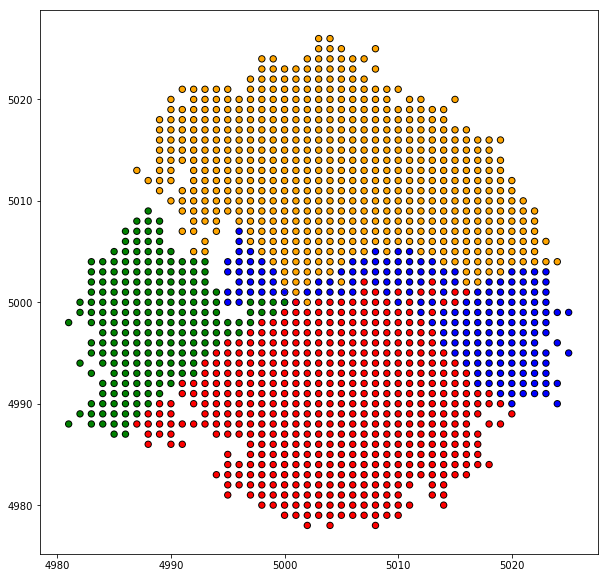

In [210]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
cmap=mpl.cm.viridis 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultation.png')
plt.show()

In [211]:
tree.traverse_tree()
tree.drawTree()

AttributeError: tree instance has no attribute 'yspan'

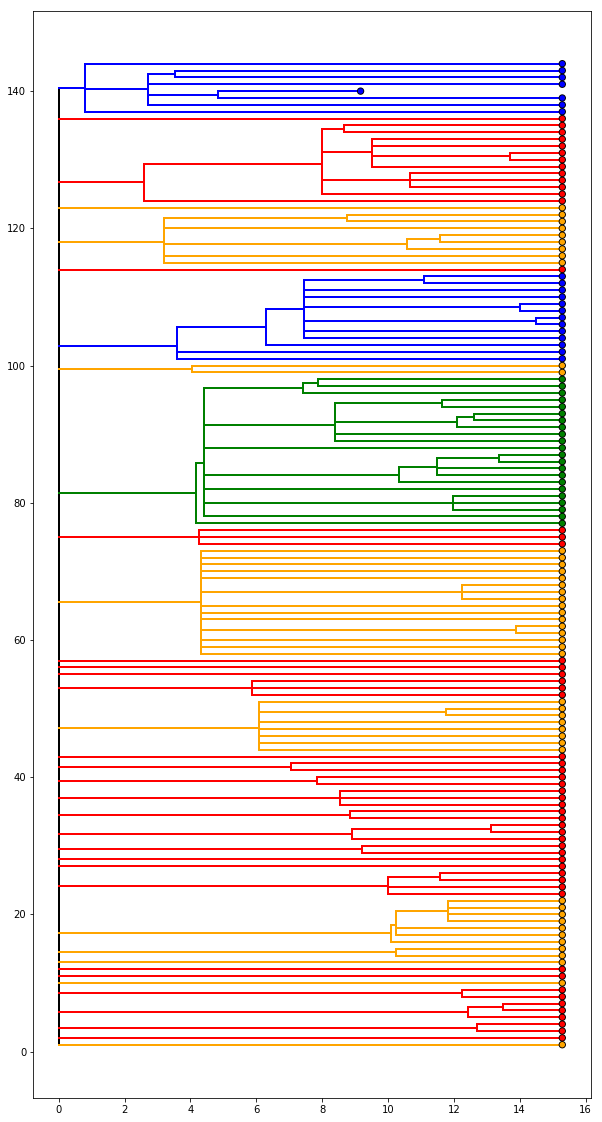

In [212]:
tree.traverse_tree()
tree.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree.yspan +5)


#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultationtree.png')
plt.show()

## Cancer stem cell model
Start w/ 4 stem cell objects that have a certain proliferation and mutation rate. These stem cells can divide to give rise to either another stem cell (symmetric division) or a clonal cell (asymmetric division) which has an assoicated mortality rate and limited proliferation capacity. 


In [700]:
def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells

def cancer_sim(founder_cells = 1,,deltat=(1/float(24)),CSC = True,stime = 10,proliferationCSC = 1, proliferationCC = 2, motility = 15, pmax = 10, mortality = 0.1,mutation = 0.1,selection = False):    
    import pandas as pd
    import numpy as np
    import random
    import copy
    import baltic as bt
    #create classes
    class Cell:
        def __init__(self):
            self.parent = None #cell it was derived from
            self.children = [] #set of daughter cells
            self.locx = None #x location in lattice
            self.locy = None #y location in lattice
            self.birthdate = None
            self.deathdate = None
            self.pmax = pmax #proliferation potential
            self.cellnum = None #unique cell number to identify
            self.alpha = 0.01 #probability of sponaneous death
            self.mutation_rate = mutation #probability of mutation per cell division
            self.motility = motility #probability of migration per day
            self.proliferation_rate = proliferationCC #average cell divisions per day
            self.clone = None
            self.mutations = []
            self.ps = 0
            self.curnode = None
            self.new_mut = False
            self.group = None


    class StemCell(Cell): #define stem cell class
        def __init__(self):
            Cell.__init__(self)
            self.pmax = float('inf') #infinite proliferation potential
            self.alpha = 0 #immortal
            self.ps = 0 #probability of symmetric division
            self.proliferation_rate = proliferationCSC
    
    class Group():
        def __init__(self):
            self.alive_cells = []
            self.node = None
            self.id = None


    #create lattice array
    N = 10000 # starting demensions of lattice
    lattice = np.empty( (N,N), dtype=object)

    #parameters
    proliferation_rate_CC = proliferationCC
    proliferation_rate_CSC = proliferationCSC
    pmax_CC = pmax
    migration_potential = motility
    alpha_CC = mortality
    cur_cellnum = 0
    cur_mutnum = 0
    cur_clonenum = 1
    cur_index = 1
    cur_group = 0
    mutation_rate = mutation
    time = 0

    tree = bt.tree() #initiate tree object to track genetic evolution
    
    #set up root for genetic tree
    root = bt.node()
    root.length=-0.01 ## branch length,
    root.height=-0.01 ## height, set by traversing the tree, which adds up branch lengths along the way
    root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
    root.index=0 ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
    root.x=-0.01## X and Y coordinates of this node, once drawTree() is called
    root.alive_cells = []
    tree.Objects.append(root)
    tree.nodes.append(root)
    tree.root = root
    root.clone = 'o'
    root.locx = int(N/2)
    root.locy = int(N/2)


    alive_cells = []
    cells = []
    mutations = []
    clones = ['a','b','c','d']

    i = int(N/2) #to place founder cell in center of lattic
    modi = [0,0,1,1]
    modj = [0,1,0,1]
    if CSC == True:
        for x in range(founder_cells):
            Fcell = StemCell() #initiate founder cells, stem-cells
            Fcell.ps = 0.05
            Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per day
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = cur_cellnum #unique cell number to identify
            cur_cellnum += 1
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
            Fcell.clone = clones[x]
            Fcell.curnode = root
            cells.append(Fcell)
            alive_cells.append(Fcell)
            Fcell.curnode.alive_cells.append(Fcell)
            lattice[Fcell.locx,Fcell.locy] = Fcell
    else:
        for x in range(founder_cells):
            Fcell = Cell() #initiate founder cells, non-stem cells
            Fcell.proliferation_rate = proliferation_rate_CC
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = cur_cellnum  #unique cell number to identify
            cur_cellnum += 1
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
            Fcell.clone = clones[x]
            cells.append(Fcell)
            alive_cells.append(Fcell)
            lattice[Fcell.locx,Fcell.locy] = Fcell
    for cell in alive_cells:
        new_node = bt.node()
        new_node.length= time - root.x ## branch length,
        new_node.height = time
        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
        new_node.parent=root ## reference to parent node of the node
        root.children.append(new_node)
        new_node.index=cur_index ## index of the character designating this object
        cur_index += 1
        new_node.locx = cell.locx
        new_node.locy = cell.locy
        new_node.alive_cells = []
        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
        cell.curnode = new_node
        new_node.clone = cell.clone
        new_node.alive_cells.append(cell)
        tree.Objects.append(new_node)
        tree.nodes.append(new_node)
        new_group = Group()
        new_group.node = new_node
        new_group.alive_cells.append(cell)
        cell.group = new_group



    #time parameters
    dt = deltat # time is equilavent to 1/24 of a day or 1 hour
    stop_time =stime#stop simulation after this many days

    
    while time < stop_time:
        time += dt
        cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
        for cell in cell_stack:
            alive = True
            r = random.uniform(0, 1)
            pd = cell.proliferation_rate * dt #probability of proliferation in time dt
            free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
            if r < pd: # Does cell attempt to divide? 
                r = random.uniform(0,1)
                pdie = cell.alpha * pd #probability of spontaneously dying
                if r < pdie:
                    alive = False
                elif len(free_cells) > 0: #is there any space to divide?
                    if cell.pmax > 0: #is cell proliferation capacity exhausted?
                        r = random.uniform(0,1)
                        if r <= cell.ps: #does cell divide asymmetrically?
                            new_cell = Cell()
                            new_cell.mutation_rate = cell.mutation_rate #probability of mutation per cell division
                            new_cell.motility = cell.motility#probability of migration per day
                            new_cell.proliferation_rate = proliferation_rate_CC #average cell divisions per day
                            new_cell.clone = cell.clone
                            new_cell.alpha = cell.alpha + 0.01
                        else:
                            #new_cell = copy.deepcopy(cell)
                            new_cell = copy.copy(cell)
                            new_cell.new_mut = False

                        new_cell.parent = cell
                        newloc = random.choice(free_cells)
                        new_cell.locx = newloc[0] #x location in lattice
                        new_cell.locy = newloc[1] #y location in lattice
                        new_cell.birthdate = time
                        new_cell.cellnum = cur_cellnum #unique cell number to identify
                        cur_cellnum += 1
                        new_cell.children = []
                        new_cell.curnode = cell.curnode
                        new_cell.clone = cell.clone
                        new_cell.group = cell.group

                        r = random.uniform(0,1)
                        if r < cell.mutation_rate: #does cell gain a mutation?
                            #new_mut = Mutation()
                            #new_mut.mutnum = cur_mutnum
                            new_mut = cur_mutnum
                            cur_mutnum +=1
                            new_cell.mutations = cell.mutations + [new_mut]
                            new_cell.new_mut = True
                            mutations.append(new_mut)
                            new_node = bt.node()
                            old_node = cell.group.node
                            new_node.length= time - old_node.x ## branch length,
                            new_node.height = time
                            new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                            new_node.parent=old_node## reference to parent node of the node
                            old_node.children.append(new_node)
                            new_node.index=cur_index ## index of the character designating this object
                            cur_index += 1
                            new_node.locx = cell.locx
                            new_node.locy = cell.locy
                            new_node.alive_cells = []
                            new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                            new_cell.curnode = new_node
                            new_node.clone = cell.clone
                            new_node2 = bt.node()
                            new_node2.length= time - old_node.x ## branch length,
                            new_node2.height = time
                            new_node2.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                            new_node2.parent=old_node## reference to parent node of the node
                            old_node.children.append(new_node2)
                            new_node2.index=cur_index ## index of the character designating this object
                            cur_index += 1
                            new_node2.locx = cell.locx
                            new_node2.locy = cell.locy
                            new_node2.alive_cells = []
                            new_node2.x=time ## X and Y coordinates of this node, once drawTree() is called
                            #cell.curnode = new_node2
                            new_node2.clone = cell.clone
                            new_group = Group()
                            new_group.node = new_node
                            new_cell.group = new_group
                            old_group = cell.group
                            old_group.node = new_node2

                            tree.Objects.append(new_node)
                            tree.nodes.append(new_node)
                            tree.Objects.append(new_node2)
                            tree.nodes.append(new_node2)
                            new_cell.pmax = pmax

                        else:
                            new_cell.mutations = cell.mutations
                        new_cell.curnode.alive_cells.append(new_cell)
                        new_cell.group.alive_cells.append(new_cell)
 
                        cell.children.append(new_cell)
                        alive_cells.append(new_cell)
                        lattice[new_cell.locx,new_cell.locy] = new_cell
                        cells.append(new_cell)
                        
                    else:
                        alive = False
                    cell.pmax -= 1
                elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                    if len(free_cells) > 0:
                        newloc = random.choose(free_cells)
                        lattice[cell.locx,cell.locy] = 'None'
                        cell.locx = newloc[0]
                        cell.locy = newloc[1]
                        lattice[newloc[0],newloc[1]] = cell
            if alive == False:
                alive_cells.remove(cell)
                cell.deathdate = time
                cell.curnode.alive_cells.remove(cell)
                cell.group.alive_cells.remove(cell)
                if len(cell.group.alive_cells) == 0:

                    new_leaf = bt.leaf()
                    new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
                    cur_index += 1
                    new_leaf.numName = new_leaf.index
                    old_node = cell.group.node
                    new_leaf.length=time - old_node.x ## branch length
                    new_leaf.absoluteTime=time ## position of tip in absolute time
                    new_leaf.parent=old_node ## parent
                    old_node.children.append(new_leaf)
                    new_leaf.x=time## position of tip on x axis if the tip were to be plotted
                    new_leaf.locx = cell.locx
                    new_leaf.locy = cell.locy
                    new_leaf.clone = cell.clone
                    tree.Objects.append(new_leaf)
                    tree.leaves.append(new_leaf)

    usedparents = []
    for cell in alive_cells:
        old_node = cell.group.node
        cell.deathdate = time
        if not (cell.group.node in usedparents):
            new_leaf = bt.leaf()
            new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
            cur_index += 1
            new_leaf.length=stop_time - old_node.x ## branch length
            new_leaf.height = stop_time
            new_leaf.absoluteTime=stop_time ## position of tip in absolute time
            new_leaf.parent=old_node ## parent
            new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
            old_node.children.append(new_leaf)
            new_leaf.numName = new_leaf.index
            new_leaf.clone = cell.clone
            tree.Objects.append(new_leaf)
            tree.leaves.append(new_leaf)
            new_leaf.locx = cell.locx
            new_leaf.locy = cell.locy
            cell.curnode = new_leaf
            usedparents.append(old_node)


    tree.treeHeight = time
    return cells, alive_cells, tree

In [588]:
cells_CSC, alive_cells_CSC,tree_CSC = cancer_sim(stime = 20,proliferationCSC = 1,proliferationCC = 1,renew = False,CSC = True,pmax = 10,mutation = 0.02)

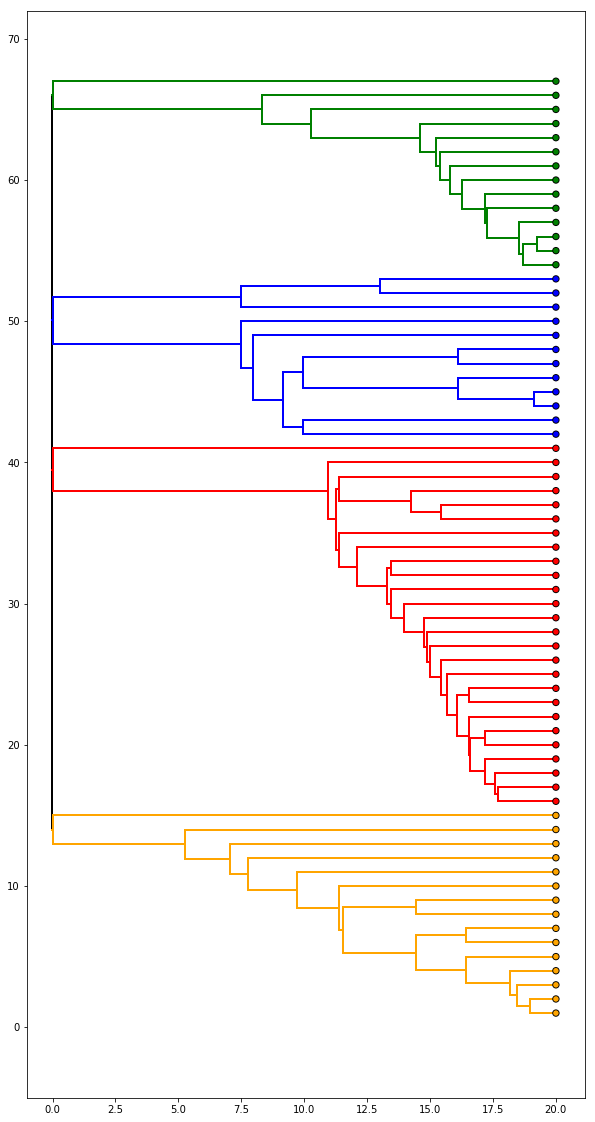

In [550]:
tree_CSC.traverse_tree()
tree_CSC.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree_CSC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree_CSC.ySpan+5)
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultationtree.png')
plt.show()

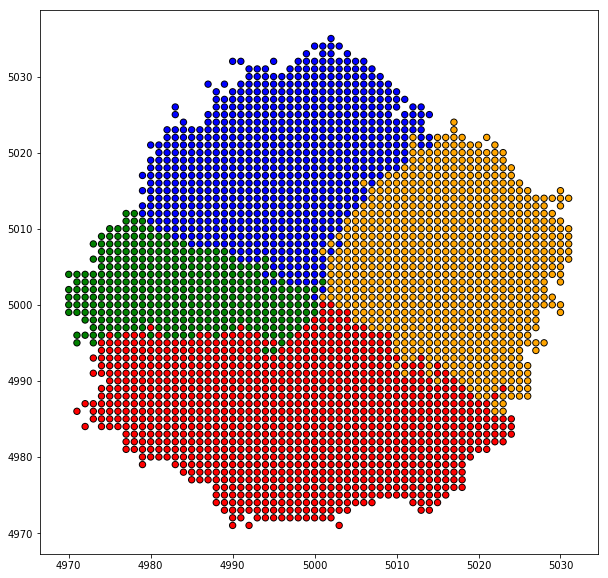

In [552]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells_CSC:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultation.png')
plt.show()

## Clonal model

In [590]:
cells_CC,alive_cells_CC,tree_CC = cancer_sim(stime = 20,proliferationCSC = .5,proliferationCC = 1,renew = False,CSC = False,pmax = 50,mutation = 0.1)

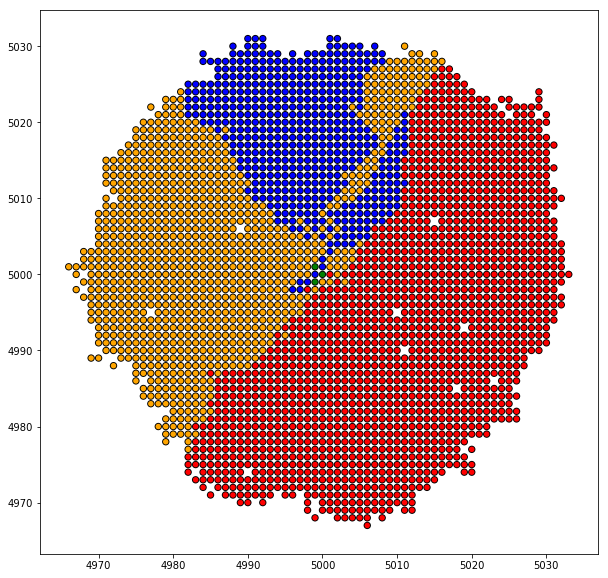

In [591]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells_CC:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultation.png')
plt.show()

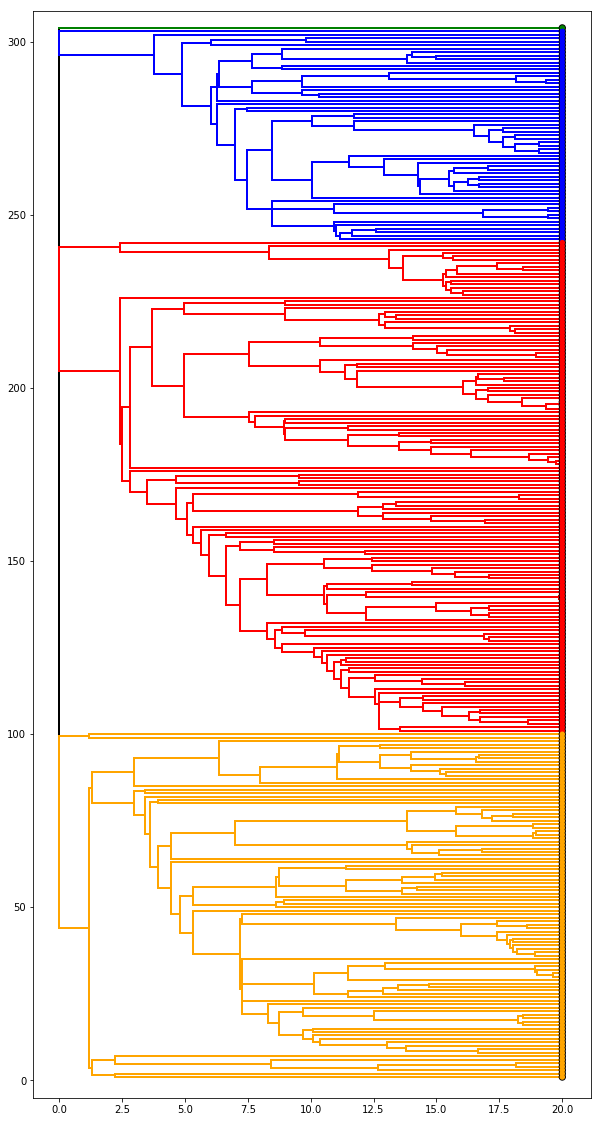

In [592]:
tree_CC.traverse_tree()
tree_CC.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree_CC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree_CC.ySpan+5)
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultationtree.png')
plt.show()

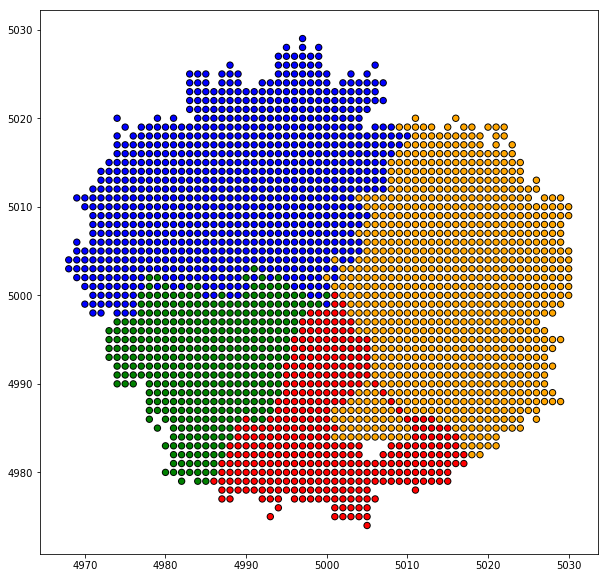

In [544]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells_CC:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultation.png')
plt.show()

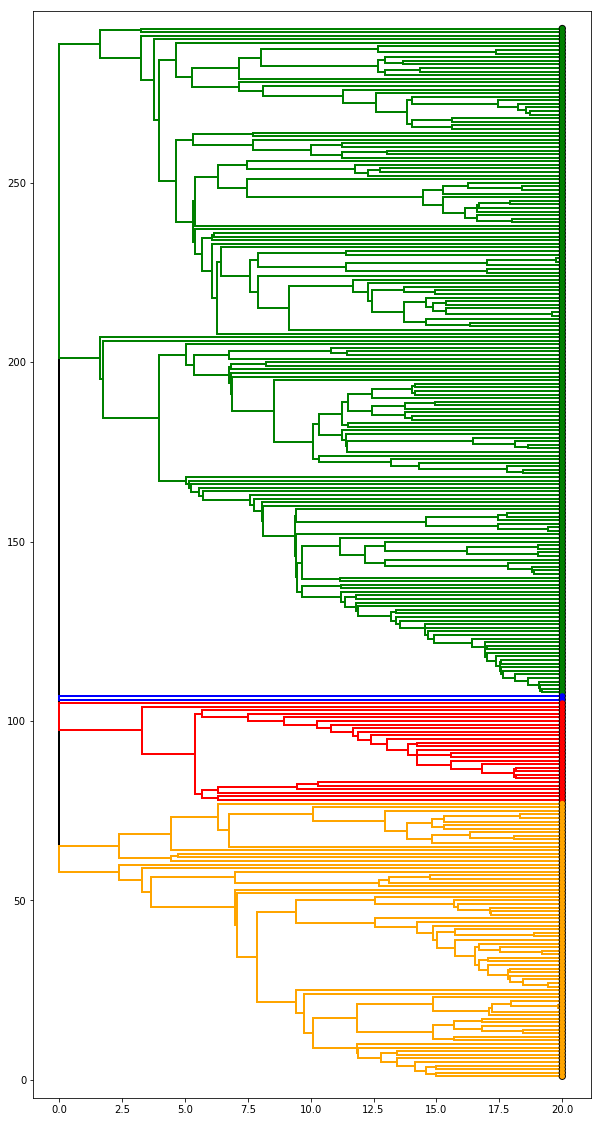

In [565]:
tree_CC.traverse_tree()
tree_CC.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree_CC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)

       
ax.set_ylim(-5,tree_CC.ySpan+5)
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultationtree.png')
plt.show()

## Calculate LBI

In [477]:
import operator
import copy
import numpy as np
def calc_LBI(tree, attr = 'lb', tau=0.0005, transform = lambda x:x):
    '''.
    traverses the tree in postorder and preorder to calculate the
    up and downstream tree length exponentially weighted by distance.
    then adds them as LBI
    tree -- dendropy tree for whose node the LBI is being computed
    attr	 -- the attribute name used to store the result

    '''
    newtree=copy.deepcopy(tree)
    newtree.postorder_node = sorted(newtree.Objects, key=operator.attrgetter('index'), reverse = True)
    newtree.preorder_internal_node = sorted(newtree.nodes, key = operator.attrgetter('index'), reverse = False)

    # traverse the tree in postorder (children first) to calculate msg to parents
    for node in newtree.postorder_node:
        node.down_polarizer = 0
        node.up_polarizer = 0
        if isinstance(node,bt.node) or node.branchType=='node':
            for child in node.children:
                node.up_polarizer += child.up_polarizer
        bl =  node.length/tau
        node.up_polarizer *= np.exp(-bl)
        node.up_polarizer += tau*(1-np.exp(-bl))

    # traverse the tree in preorder (parents first) to calculate msg to children
    for node in newtree.preorder_internal_node:
        for child1 in node.children:
            child1.down_polarizer = node.down_polarizer
        for child2 in node.children:
            if child1!=child2:
                child1.down_polarizer += child2.up_polarizer

        bl =  child1.length/tau
        child1.down_polarizer *= np.exp(-bl)
        child1.down_polarizer += tau*(1-np.exp(-bl))

    # go over all nodes and calculate the LBI (can be done in any order)
    for node in newtree.postorder_node:
        tmp_LBI = node.down_polarizer
        if isinstance(node,bt.node) or node.branchType=='node':
            for child in node.children:
                tmp_LBI += child.up_polarizer
    #node.__setattr__(attr, transform(tmp_LBI))
        setattr(node, attr, transform(tmp_LBI))
    return newtree

In [514]:
import pandas as pd
def rank_LBI(tree):
    #assert hasattr(tree, 'lb'), 'tree must have LBI attribute lb'
    newtree = copy.deepcopy(tree)
    leaves_lb = []
    for k in newtree.leaves:
        leaves_lb.append(k.lb)
        #index_list.append(leaf.name)
    lb_series = pd.Series(leaves_lb)
    ranked_lb = lb_series.rank(pct = True)
    i = 0
    for k in newtree.leaves:
        setattr(k, 'rank', ranked_lb[i])
        k.rank = ranked_lb[i]
        i += 1
    return newtree


### For CSC model

In [515]:
ttree = calc_LBI(tree_CSC,tau = 2)
rtree = rank_LBI(ttree)

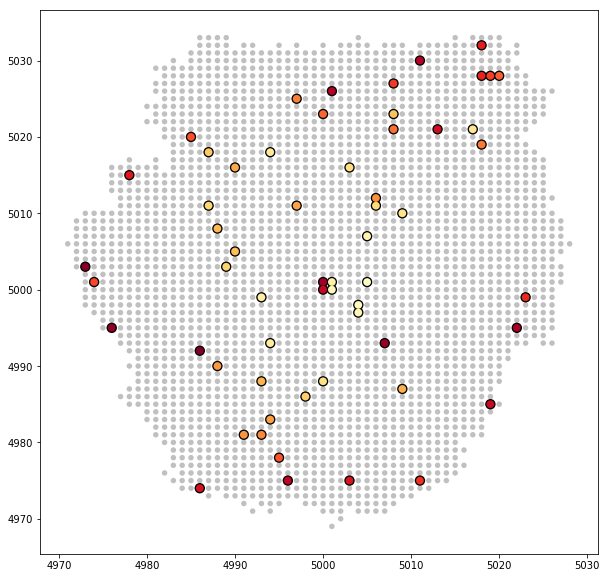

In [517]:
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
cmap=mpl.cm.YlOrRd
for l in rtree.leaves:
#     c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
    c = cmap(l.rank)
    branchWidth=2 ## default branch width
    x = l.locx
    y = l.locy
    s = 60
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
for a in alive_cells_CSC:
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor='silver',edgecolor='none',zorder=9) ## plot circle for every tip

    
plt.savefig('figures/CSCsimultation_LBI.png')
plt.show()

## Genealogy

### Clonal model

In [980]:
def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells

def cancer_sim(founder_cells = 1,deltat=(1/float(24)),CSC = True,stime = 10,proliferationCSC = 1, proliferationCC = 2, motility = 15, pmax = 10, mortality = 0.1, mutation = 0.1, selection = False):    
    import pandas as pd
    import numpy as np
    import random
    import copy
    import baltic as bt
    #create classes
    class Cell:
        def __init__(self):
            self.parent = None #cell it was derived from
            self.children = [] #set of daughter cells
            self.locx = None #x location in lattice
            self.locy = None #y location in lattice
            self.birthdate = None
            self.deathdate = None
            self.pmax = pmax #proliferation potential
            self.cellnum = None #unique cell number to identify
            self.alpha = 0.01 #probability of sponaneous death
            self.mutation_rate = mutation #probability of mutation per cell division
            self.motility = motility #probability of migration per day
            self.proliferation_rate = proliferationCC #average cell divisions per day
            self.clone = None
            self.mutations = []
            self.ps = 0
            self.curnode = None
            self.new_mut = False
            self.group = None
            self.alive = True


    class StemCell(Cell): #define stem cell class
        def __init__(self):
            Cell.__init__(self)
            self.pmax = float('inf') #infinite proliferation potential
            self.alpha = 0 #immortal
            self.ps = 0 #probability of symmetric division
            self.proliferation_rate = proliferationCSC
            self.alive = True
    
    class Group():
        def __init__(self):
            self.alive_cells = []
            self.node = None
            self.id = None


    #create lattice array
    N = 10000 # starting demensions of lattice
    lattice = np.empty( (N,N), dtype=object)

    #parameters
    proliferation_rate_CC = proliferationCC
    proliferation_rate_CSC = proliferationCSC
    pmax_CC = pmax
    migration_potential = motility
    alpha_CC = mortality
    cur_cellnum = 0
    cur_mutnum = 0
    cur_clonenum = 1
    cur_index = 1
#     cur_group = 0
    mutation_rate = mutation
    time = 0

#     tree = bt.tree() #initiate tree object to track genetic evolution
    
#     #set up root for genetic tree
#     root = bt.node()
#     root.length=-0.01 ## branch length,
#     root.height=-0.01 ## height, set by traversing the tree, which adds up branch lengths along the way
#     root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
#     root.index=0 ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
#     root.x=-0.01## X and Y coordinates of this node, once drawTree() is called
#     root.alive_cells = []
#     tree.Objects.append(root)
#     tree.nodes.append(root)
#     tree.root = root
#     root.clone = 'o'
#     root.locx = int(N/2)
#     root.locy = int(N/2)


    alive_cells = []
    cells = []
    mutations = []
#     clones = ['a','b','c','d']

    i = int(N/2) #to place founder cell in center of lattic
    modi = [0,0,1,1]
    modj = [0,1,0,1]
    if CSC == True:
        for x in range(founder_cells):
            Fcell = StemCell() #initiate founder cells, stem-cells
            Fcell.ps = 0.05
            Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per day
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = cur_cellnum #unique cell number to identify
            cur_cellnum += 1
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
#             Fcell.clone = clones[x]
#             Fcell.curnode = root
            cells.append(Fcell)
            alive_cells.append(Fcell)
#             Fcell.curnode.alive_cells.append(Fcell)
            lattice[Fcell.locx,Fcell.locy] = Fcell
    else:
        for x in range(founder_cells):
            Fcell = Cell() #initiate founder cells, non-stem cells
            Fcell.proliferation_rate = proliferation_rate_CC
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = cur_cellnum  #unique cell number to identify
            cur_cellnum += 1
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
#             Fcell.clone = clones[x]
            cells.append(Fcell)
            alive_cells.append(Fcell)
            lattice[Fcell.locx,Fcell.locy] = Fcell
#     for cell in alive_cells:
#         new_node = bt.node()
#         new_node.length= time - root.x ## branch length,
#         new_node.height = time
#         new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
#         new_node.parent=root ## reference to parent node of the node
#         root.children.append(new_node)
#         new_node.index=cur_index ## index of the character designating this object
#         cur_index += 1
#         new_node.locx = cell.locx
#         new_node.locy = cell.locy
#         new_node.alive_cells = []
#         new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
#         cell.curnode = new_node
#         new_node.clone = cell.clone
#         new_node.alive_cells.append(cell)
#         tree.Objects.append(new_node)
#         tree.nodes.append(new_node)
#         new_group = Group()
#         new_group.node = new_node
#         new_group.alive_cells.append(cell)
#         cell.group = new_group



    #time parameters
    dt = deltat # time is equilavent to 1/24 of a day or 1 hour
    stop_time =stime#stop simulation after this many days

    
    while time < stop_time:
        time += dt
        cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
        for cell in cell_stack:
            alive = True
            r = random.uniform(0, 1)
            pd = cell.proliferation_rate * dt #probability of proliferation in time dt
            free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
            if r < pd: # Does cell attempt to divide? 
                r = random.uniform(0,1)
                pdie = cell.alpha * pd #probability of spontaneously dying
                if r < pdie:
                    alive = False
                elif len(free_cells) > 0: #is there any space to divide?
                    if cell.pmax > 0: #is cell proliferation capacity exhausted?
                        r = random.uniform(0,1)
                        if r <= cell.ps: #does cell divide asymmetrically?
                            new_cell = Cell()
                            new_cell.mutation_rate = cell.mutation_rate #probability of mutation per cell division
                            new_cell.motility = cell.motility#probability of migration per day
                            new_cell.proliferation_rate = proliferation_rate_CC #average cell divisions per day
#                             new_cell.clone = cell.clone
                            new_cell.alpha = cell.alpha + 0.01
                        else:
                            #new_cell = copy.deepcopy(cell)
                            new_cell = copy.copy(cell)
                            new_cell.new_mut = False

                        new_cell.parent = cell
                        newloc = random.choice(free_cells)
                        new_cell.locx = newloc[0] #x location in lattice
                        new_cell.locy = newloc[1] #y location in lattice
                        new_cell.birthdate = time
                        new_cell.cellnum = cur_cellnum #unique cell number to identify
                        cur_cellnum += 1
                        new_cell.children = []
#                         new_cell.curnode = cell.curnode
#                         new_cell.clone = cell.clone
#                         new_cell.group = cell.group

                        r = random.uniform(0,1)
                        if r < cell.mutation_rate: #does cell gain a mutation?
                            #new_mut = Mutation()
                            #new_mut.mutnum = cur_mutnum
                            new_mut = cur_mutnum
                            cur_mutnum +=1
                            new_cell.mutations = cell.mutations + [new_mut]
                            new_cell.new_mut = True
                            mutations.append(new_mut)
#                             new_node = bt.node()
#                             old_node = cell.group.node
#                             new_node.length= time - old_node.x ## branch length,
#                             new_node.height = time
#                             new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
#                             new_node.parent=old_node## reference to parent node of the node
#                             old_node.children.append(new_node)
#                             new_node.index=cur_index ## index of the character designating this object
#                             cur_index += 1
#                             new_node.locx = cell.locx
#                             new_node.locy = cell.locy
#                             new_node.alive_cells = []
#                             new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
#                             new_cell.curnode = new_node
#                             new_node.clone = cell.clone
#                             new_node2 = bt.node()
#                             new_node2.length= time - old_node.x ## branch length,
#                             new_node2.height = time
#                             new_node2.absoluteTime=time ## branch end point in absolute time, once calibrations are done
#                             new_node2.parent=old_node## reference to parent node of the node
#                             old_node.children.append(new_node2)
#                             new_node2.index=cur_index ## index of the character designating this object
#                             cur_index += 1
#                             new_node2.locx = cell.locx
#                             new_node2.locy = cell.locy
#                             new_node2.alive_cells = []
#                             new_node2.x=time ## X and Y coordinates of this node, once drawTree() is called
#                             #cell.curnode = new_node2
#                             new_node2.clone = cell.clone
#                             new_group = Group()
#                             new_group.node = new_node
#                             new_cell.group = new_group
#                             old_group = cell.group
#                             old_group.node = new_node2

#                             tree.Objects.append(new_node)
#                             tree.nodes.append(new_node)
#                             tree.Objects.append(new_node2)
#                             tree.nodes.append(new_node2)
                            new_cell.pmax = pmax

                        else:
                            new_cell.mutations = cell.mutations
#                         new_cell.curnode.alive_cells.append(new_cell)
#                         new_cell.group.alive_cells.append(new_cell)
 
                        cell.children.append(new_cell)
                        alive_cells.append(new_cell)
                        lattice[new_cell.locx,new_cell.locy] = new_cell
                        cells.append(new_cell)
                        
                    else:
                        alive = False
                    cell.pmax -= 1
                elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                    if len(free_cells) > 0:
                        newloc = random.choose(free_cells)
                        lattice[cell.locx,cell.locy] = 'None'
                        cell.locx = newloc[0]
                        cell.locy = newloc[1]
                        lattice[newloc[0],newloc[1]] = cell
            if alive == False:
                alive_cells.remove(cell)
                cell.alive = False
                cell.deathdate = time
#                 cell.curnode.alive_cells.remove(cell)
#                 cell.group.alive_cells.remove(cell)
#                 if len(cell.group.alive_cells) == 0:

#                     new_leaf = bt.leaf()
#                     new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
#                     cur_index += 1
#                     new_leaf.numName = new_leaf.index
#                     old_node = cell.group.node
#                     new_leaf.length=time - old_node.x ## branch length
#                     new_leaf.absoluteTime=time ## position of tip in absolute time
#                     new_leaf.parent=old_node ## parent
#                     old_node.children.append(new_leaf)
#                     new_leaf.x=time## position of tip on x axis if the tip were to be plotted
#                     new_leaf.locx = cell.locx
#                     new_leaf.locy = cell.locy
#                     new_leaf.clone = cell.clone
#                     tree.Objects.append(new_leaf)
#                     tree.leaves.append(new_leaf)

#     usedparents = []
    for cell in alive_cells:
        #old_node = cell.group.node
        cell.deathdate = time
#         if not (cell.group.node in usedparents):
#             new_leaf = bt.leaf()
#             new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
#             cur_index += 1
#             new_leaf.length=stop_time - old_node.x ## branch length
#             new_leaf.height = stop_time
#             new_leaf.absoluteTime=stop_time ## position of tip in absolute time
#             new_leaf.parent=old_node ## parent
#             new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
#             old_node.children.append(new_leaf)
#             new_leaf.numName = new_leaf.index
#             new_leaf.clone = cell.clone
#             tree.Objects.append(new_leaf)
#             tree.leaves.append(new_leaf)
#             new_leaf.locx = cell.locx
#             new_leaf.locy = cell.locy
#             cell.curnode = new_leaf
#             usedparents.append(old_node)


#     tree.treeHeight = time
    return cells, alive_cells

In [925]:
cells_CC, alive_cells_CC = cancer_sim(founder_cells = 1,stime = 20,proliferationCSC = .5,proliferationCC = 1,CSC = False,pmax = 10,mutation = 0.1)

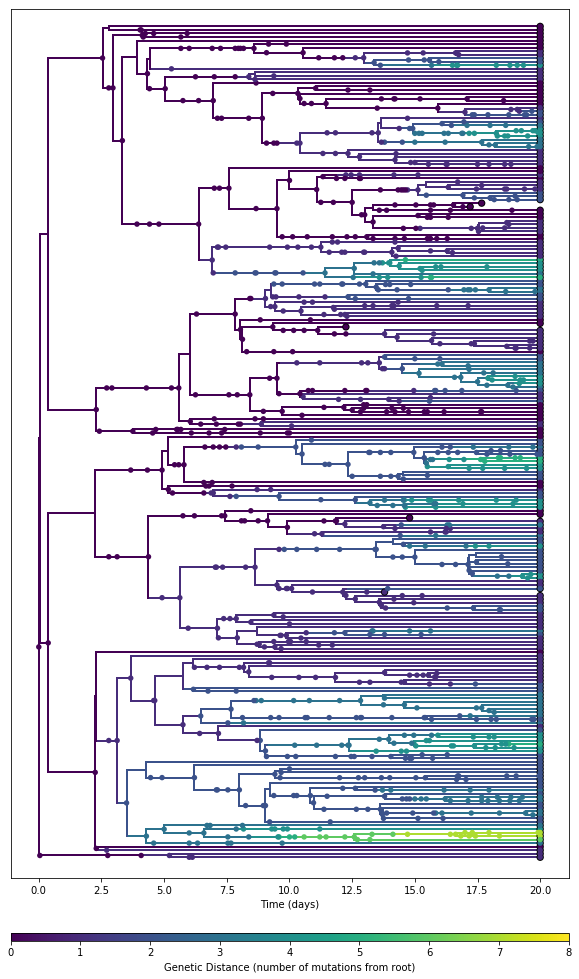

In [962]:
##Choose random percentage of alive_cells and collect the parents of these cells
fraction = 0.1
cells_copy = copy.deepcopy(cells_CC)

sample = random.sample(cells_copy, int(fraction*float(len(cells_copy))))
pruned_cells = []
genealogy_tree_CC = bt.tree() #initiate tree object to track cellular replication
cur_index = 0


for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell != None:
        pruned_cells.append(curcell)
        curcell.node = None
        curcell = curcell.parent
        
pruned_cells = np.unique(pruned_cells)
postorder_nodes = sorted(pruned_cells, key=operator.attrgetter('birthdate'), reverse = True)

for cell in pruned_cells:
    cell.children = []
    
for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell.parent != None:
        if not curcell in curcell.parent.children:
            curcell.parent.children.append(curcell)
        curcell = curcell.parent


for leaf in sample: #make leaf and node for each terminal cell sample and it's proximal division
    new_leaf = bt.leaf()
    new_leaf.x = leaf.deathdate
    new_leaf.height = leaf.deathdate
    new_leaf.mutations = leaf.mutations
    new_leaf.index = cur_index
    new_leaf.numName = cur_index
    cur_index += 1
    new_leaf.locx = leaf.locx
    new_leaf.locy = leaf.locy
    leaf.leaf = new_leaf
    genealogy_tree_CC.Objects.append(new_leaf)
    genealogy_tree_CC.leaves.append(new_leaf)

for cell in postorder_nodes: #make nodes for each cell division and add node lineages
    new_node = bt.node()
    new_node.x = cell.birthdate
    new_node.height = cell.birthdate 
    new_node.mutations = cell.mutations
    new_node.real_cell = True
    new_node.index = cur_index
    cur_index += 1
    sorted_children =  sorted(cell.children, key=operator.attrgetter('cellnum'), reverse = False)
    cell.node = new_node
    parents = [new_node]
    for i in range(len(sorted_children)):
#         if ((i < (len(sorted_children)) -1 ) or (cell in sample)):
        if (i < len(sorted_children) -1 ) or (cell in sample):
            renew_node = bt.node()
            renew_node.x = sorted_children[i].birthdate
            renew_node.height = sorted_children[i].birthdate
            renew_node.mutations = cell.mutations
            renew_node.length = sorted_children[i].birthdate - parents[i].height
            renew_node.index = cur_index
            renew_node.parent = parents[i]
            renew_node.real_cell = False
            parents[i].children.append(renew_node)
            cur_index += 1
            parents.append(renew_node)
            genealogy_tree_CC.Objects.append(renew_node)
            genealogy_tree_CC.nodes.append(renew_node)
        sorted_children[i].node.parent = parents[i]
        sorted_children[i].node.length = sorted_children[i].node.height - parents[i].height
        parents[i].children.append(sorted_children[i].node)
    if cell in sample:
        parents[-1].children.append(cell.leaf)
        cell.leaf.parent = parents[-1]
        cell.leaf.length = cell.leaf.height - parents[-1].height
    if cell.cellnum== 0:
        genealogy_tree_CC.root = new_node
        new_node.length = 0
    genealogy_tree_CC.Objects.append(new_node)
    genealogy_tree_CC.nodes.append(new_node)

genealogy_tree_CC.treeHeight = sorted(sample, key=operator.attrgetter('deathdate'), reverse = True)[0].deathdate
genealogy_tree_CC.traverse_tree()
genealogy_tree_CC.drawTree() 

fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors


max_muts_all = 0
for a in alive_cells_CC:
    if max_muts_all < len(a.mutations):
        max_muts_all = len(a.mutations)

for k in genealogy_tree_CC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x

    c =  cmap(len(k.mutations)/float(max_muts_all))

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        if k.real_cell == True:
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,genealogy_tree_CC.ySpan+5)

import matplotlib.colors as mcolors
import matplotlib.cm as cm

##set up colorbar
norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
scalarmappaple.set_array(range(max_muts_all))
cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.05)
cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
#cbar.ax.text(3,0.75,'Genetic Distance (number of mutations from root)',rotation=90)

# ax.spines['top'].set_visible(False) ## no axes
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time (days)')


#ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('figures/simultation_genealogy_tree.png')
plt.show()

    


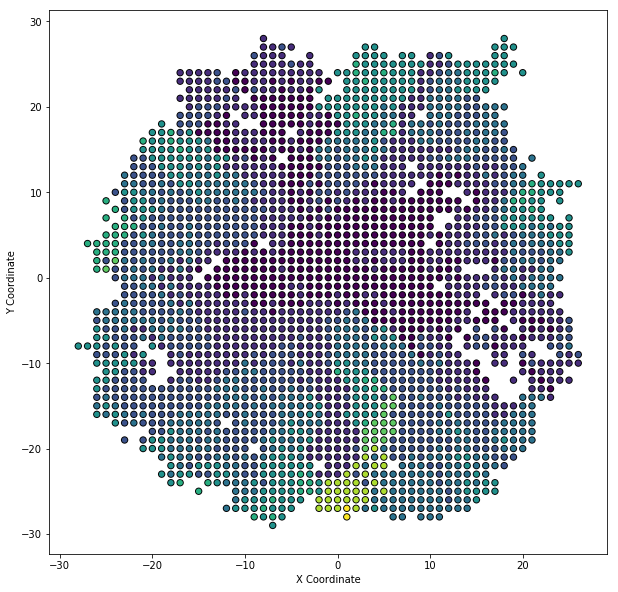

In [963]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}

startx = 5000
starty = 5000
for a in alive_cells_CC:
    c =  cmap(len(a.mutations)/float(max_muts_all))
# default branch width
    x = a.locx - startx
    y = a.locy - starty
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    ax.set_ylabel('Y Coordinate')
    ax.set_xlabel('X Coordinate')
    
plt.savefig('figures/CCsimultation_alive_cells.png')
plt.show()

In [982]:
cells_CSC, alive_cells_CSC = cancer_sim(founder_cells = 1,stime = 20,proliferationCSC = .5,proliferationCC = 1,CSC = True,pmax = 10,mutation = 0.1)

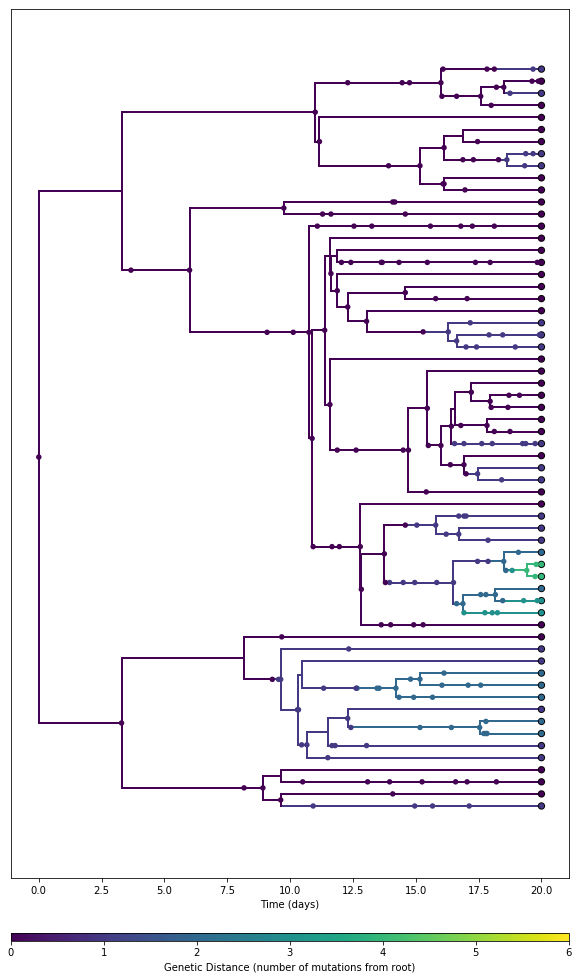

In [983]:
##Choose random percentage of alive_cells and collect the parents of these cells
fraction = 0.1
cells_copy = copy.deepcopy(cells_CSC)

sample = random.sample(cells_copy, int(fraction*float(len(cells_copy))))
pruned_cells = []
genealogy_tree_CSC = bt.tree() #initiate tree object to track cellular replication
cur_index = 0


for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell != None:
        pruned_cells.append(curcell)
        curcell.node = None
        curcell = curcell.parent
        
pruned_cells = np.unique(pruned_cells)
postorder_nodes = sorted(pruned_cells, key=operator.attrgetter('birthdate'), reverse = True)

for cell in pruned_cells:
    cell.children = []
    
for cell in sample: #get all ancestor cells from randomly samples leaves
    curcell = cell
    while curcell.parent != None:
        if not curcell in curcell.parent.children:
            curcell.parent.children.append(curcell)
        curcell = curcell.parent


for leaf in sample: #make leaf and node for each terminal cell sample and it's proximal division
    new_leaf = bt.leaf()
    new_leaf.x = leaf.deathdate
    new_leaf.height = leaf.deathdate
    new_leaf.mutations = leaf.mutations
    new_leaf.index = cur_index
    new_leaf.numName = cur_index
    cur_index += 1
    new_leaf.locx = leaf.locx
    new_leaf.locy = leaf.locy
    leaf.leaf = new_leaf
    genealogy_tree_CSC.Objects.append(new_leaf)
    genealogy_tree_CSC.leaves.append(new_leaf)

for cell in postorder_nodes: #make nodes for each cell division and add node lineages
    new_node = bt.node()
    new_node.x = cell.birthdate
    new_node.height = cell.birthdate 
    new_node.mutations = cell.mutations
    new_node.real_cell = True
    new_node.index = cur_index
    cur_index += 1
    sorted_children =  sorted(cell.children, key=operator.attrgetter('cellnum'), reverse = False)
    cell.node = new_node
    parents = [new_node]
    for i in range(len(sorted_children)):
#         if ((i < (len(sorted_children)) -1 ) or (cell in sample)):
        if (i < len(sorted_children) -1 ) or (cell in sample):
            renew_node = bt.node()
            renew_node.x = sorted_children[i].birthdate
            renew_node.height = sorted_children[i].birthdate
            renew_node.mutations = cell.mutations
            renew_node.length = sorted_children[i].birthdate - parents[i].height
            renew_node.index = cur_index
            renew_node.parent = parents[i]
            renew_node.real_cell = False
            parents[i].children.append(renew_node)
            cur_index += 1
            parents.append(renew_node)
            genealogy_tree_CSC.Objects.append(renew_node)
            genealogy_tree_CSC.nodes.append(renew_node)
        sorted_children[i].node.parent = parents[i]
        sorted_children[i].node.length = sorted_children[i].node.height - parents[i].height
        parents[i].children.append(sorted_children[i].node)
    if cell in sample:
        parents[-1].children.append(cell.leaf)
        cell.leaf.parent = parents[-1]
        cell.leaf.length = cell.leaf.height - parents[-1].height
    if cell.cellnum== 0:
        genealogy_tree_CSC.root = new_node
        new_node.length = 0
    genealogy_tree_CSC.Objects.append(new_node)
    genealogy_tree_CSC.nodes.append(new_node)

genealogy_tree_CSC.treeHeight = sorted(sample, key=operator.attrgetter('deathdate'), reverse = True)[0].deathdate
genealogy_tree_CSC.traverse_tree()
genealogy_tree_CSC.drawTree() 

fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors
# max_muts = 0
# for k in genealogy_tree_CC.Objects:
#     if max_muts < len(k.mutations):
#         max_muts = len(k.mutations)

max_muts_all = 0
for a in alive_cells_CSC:
    if max_muts_all < len(a.mutations):
        max_muts_all = len(a.mutations)

for k in genealogy_tree_CSC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x

    c =  cmap(len(k.mutations)/float(max_muts_all))

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        if k.real_cell == True:
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,genealogy_tree_CSC.ySpan+5)

import matplotlib.colors as mcolors
import matplotlib.cm as cm

##set up colorbar
norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
scalarmappaple.set_array(range(max_muts_all))
cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.05)
cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
#cbar.ax.text(3,0.75,'Genetic Distance (number of mutations from root)',rotation=90)

# ax.spines['top'].set_visible(False) ## no axes
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time (days)')


#ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
#ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('figures/simultation_genealogy_tree.png')
plt.show()

    


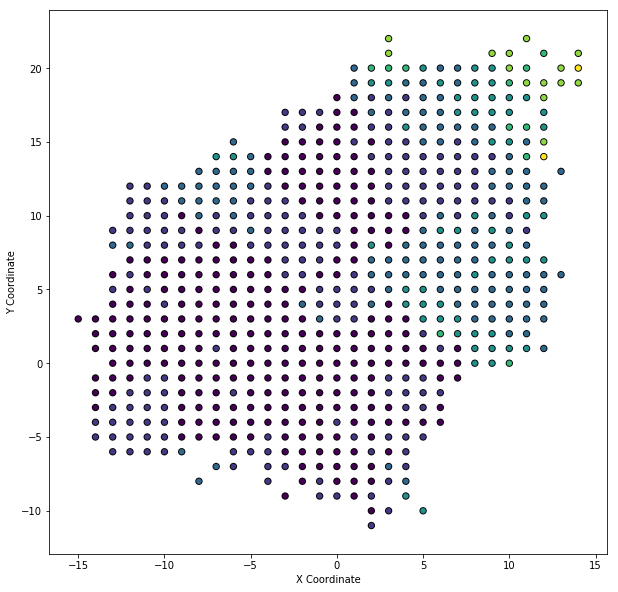

In [984]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}

startx = 5000
starty = 5000
for a in alive_cells_CSC:
    c =  cmap(len(a.mutations)/float(max_muts_all))
# default branch width
    x = a.locx - startx
    y = a.locy - starty
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
ax.set_ylabel('Y Coordinate')
ax.set_xlabel('X Coordinate')
# norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
# scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
# scalarmappaple.set_array(range(max_muts_all))
# cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.1)
# cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
    
plt.savefig('figures/CCsimultation_alive_cells.png')
plt.show()

## LBI of cells

This is a modified LBI. It takes into account the "branching" of each cells, as in the divisions of itself, parents, and children immediate to the cell when it first arose. This is in contrast to 

In [876]:
import operator
import copy
import numpy as np
def calc_LBI_cells(cells, attr = 'lb', tau=0.0005, transform = lambda x:x):
    '''.
    traverses the tree in postorder and preorder to calculate the
    up and downstream tree length exponentially weighted by distance.
    then adds them as LBI
    tree -- dendropy tree for whose node the LBI is being computed
    attr	 -- the attribute name used to store the result

    '''
    new_cells=copy.deepcopy(cells)
    postorder_node = sorted(new_cells, key=operator.attrgetter('cellnum'), reverse = True)
    nodes = [x for x in new_cells if len(x.children) > 1]
    preorder_internal_node = sorted(nodes, key = operator.attrgetter('cellnum'), reverse = False)
    
    for cell in new_cells:
        if cell.cellnum != 0:
            sorted_siblings = sorted(cell.parent.children, key = operator.attrgetter('cellnum'), reverse = False)
            cindx = sorted_siblings.index(cell)
            cell.length = cell.birthdate - sorted_siblings[cindx-1].birthdate
        else:
            cell.length = 0
    # traverse the tree in postorder (children first) to calculate msg to parents
    for node in postorder_node:
        node.down_polarizer = 0
        node.up_polarizer = 0
        if len(node.children) > 0:
            for child in node.children:
                node.up_polarizer += child.up_polarizer
        bl =  node.length/tau
        node.up_polarizer *= np.exp(-bl)
        node.up_polarizer += tau*(1-np.exp(-bl))

    # traverse the tree in preorder (parents first) to calculate msg to children
    for node in preorder_internal_node:
        for child1 in node.children:
            child1.down_polarizer = node.down_polarizer
        for child2 in node.children:
            if child1!=child2:
                child1.down_polarizer += child2.up_polarizer

        bl =  child1.length/tau

        child1.down_polarizer *= np.exp(-bl)
        child1.down_polarizer += tau*(1-np.exp(-bl))

    # go over all nodes and calculate the LBI (can be done in any order)
    for node in postorder_node:
        tmp_LBI = node.down_polarizer
        if len(node.children) > 0:
            for child in node.children:
                tmp_LBI += child.up_polarizer
    #node.__setattr__(attr, transform(tmp_LBI))
        setattr(node, attr, transform(tmp_LBI))
    return new_cells

In [968]:
import pandas as pd
def rank_LBI_cells(tree,alive_cells):
    #assert hasattr(tree, 'lb'), 'tree must have LBI attribute lb'
    newtree = copy.deepcopy(tree)
    leaves_lb = []
    leaves =  [x for x in newtree if x.alive == True]
    for k in leaves:
        leaves_lb.append(k.lb)
        #index_list.append(leaf.name)
    lb_series = pd.Series(leaves_lb)
    ranked_lb = lb_series.rank(pct = True)
    i = 0
    for k in leaves:
        setattr(k, 'rank', ranked_lb[i])
        k.rank = ranked_lb[i]
        i += 1
    return leaves


In [985]:
lbi_cells_CC = calc_LBI_cells(cells_CC, tau = 1)
rank_cells_CC = rank_LBI_cells(lbi_cells_CC, alive_cells_CC)
lbi_cells_CSC = calc_LBI_cells(cells_CSC, tau = 1)
rank_cells_CSC = rank_LBI_cells(lbi_cells_CSC, alive_cells_CSC)

### Spatial LBI rank

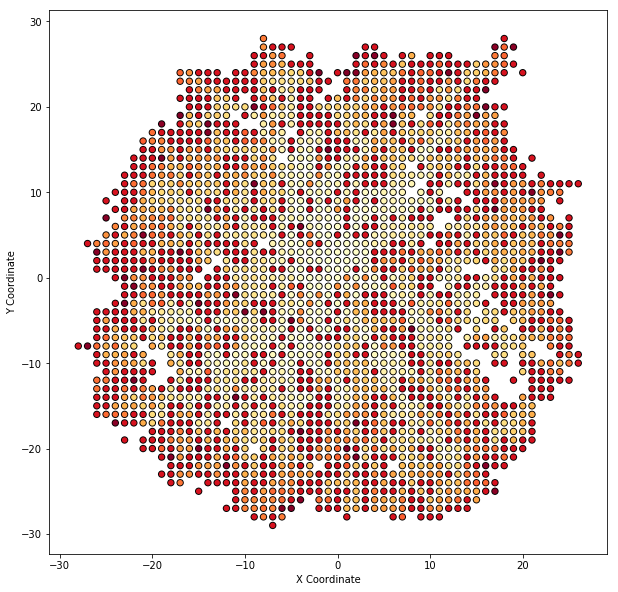

In [976]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
cmap2=mpl.cm.YlOrRd
startx = 5000
starty = 5000
for a in rank_cells_CC:
    c =  cmap2(a.rank)
# default branch width
    x = a.locx - startx
    y = a.locy - starty
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
ax.set_ylabel('Y Coordinate')
ax.set_xlabel('X Coordinate')
# norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
# scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
# scalarmappaple.set_array(range(max_muts_all))
# cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.1)
# cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
    
plt.savefig('figures/CCsimultation_spatial_LBI_CC.png')
plt.show()

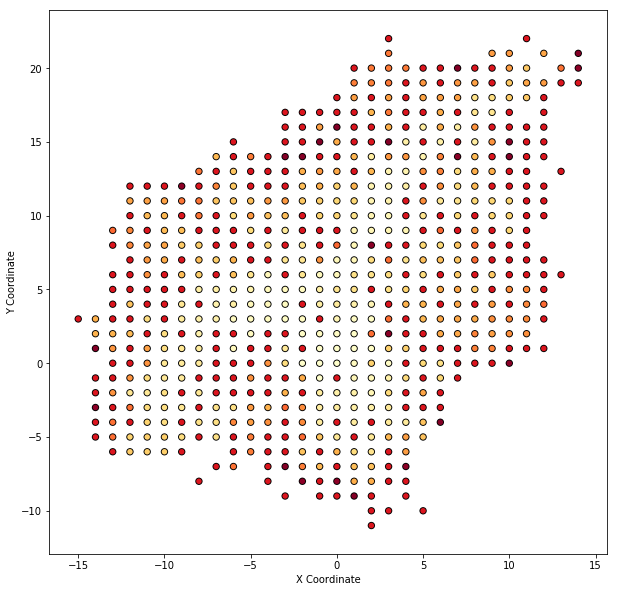

In [986]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
cmap2=mpl.cm.YlOrRd
startx = 5000
starty = 5000
for a in rank_cells_CSC:
    c =  cmap2(a.rank)
# default branch width
    x = a.locx - startx
    y = a.locy - starty
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
ax.set_ylabel('Y Coordinate')
ax.set_xlabel('X Coordinate')
# norm= mcolors.Normalize(vmin=0, vmax=max_muts_all)
# scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
# scalarmappaple.set_array(range(max_muts_all))
# cbar = plt.colorbar(scalarmappaple,aspect = 70,orientation = 'horizontal',pad = 0.1)
# cbar.set_label('Genetic Distance (number of mutations from root)', rotation=0)
    
plt.savefig('figures/CCsimultation_spatial_LBI_CSC.png')
plt.show()